In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [3]:
#seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### READING DATA

- `train_data` & `test_data` are the csv files given on zindi
- Both train and test images are in the same folder, so `train_path` and `test_path` are the same

In [4]:
#reading data
#Change path to your images and csv files path 
train_data = pd.read_csv('/content/drive/MyDrive/Zindi pothole image classification/data/train_ids_labels.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Zindi pothole image classification/data/test_ids_only.csv')
train_path = '/content/drive/MyDrive/Zindi pothole image classification/all_data/'
test_path = '/content/drive/MyDrive/Zindi pothole image classification/all_data/'

In [5]:
train_data.head()

,Image_ID,Label
0,cVOfkSdqnWXUerr,0
1,EhnvIDPXFFjUhkR,0
2,tYKqoStvHsryFhS,1
3,eSpjlsZIwOMLmUS,1
4,uzxhIXjNENLyHwZ,1


###  creating train and test dataframe

- Here i created two dataframes so we can use tensorflows `.flow_from_dataframe` to load the images

In [6]:
#we will create dataframes and use keras Image data preprocessing function: flow_from_dataframe

# train
train_names = train_data.Image_ID.values
train_labels = np.asarray(train_data['Label'].values)
train_dict = {'filepath': train_path + train_names + '.JPG', 'Label': train_labels}
train = pd.DataFrame(data=train_dict)

# test
test_names = test_data.Image_ID.values
test_dict = {'filepath': test_path + test_names + '.JPG'}
test = pd.DataFrame(data=test_dict)

In [7]:
train.head()

,filepath,Label
0,/content/drive/MyDrive/Zindi pothole image cla...,0
1,/content/drive/MyDrive/Zindi pothole image cla...,0
2,/content/drive/MyDrive/Zindi pothole image cla...,1
3,/content/drive/MyDrive/Zindi pothole image cla...,1
4,/content/drive/MyDrive/Zindi pothole image cla...,1


In [8]:
train.shape, test.shape

((4026, 2), (1650, 1))

### Quick EDA

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


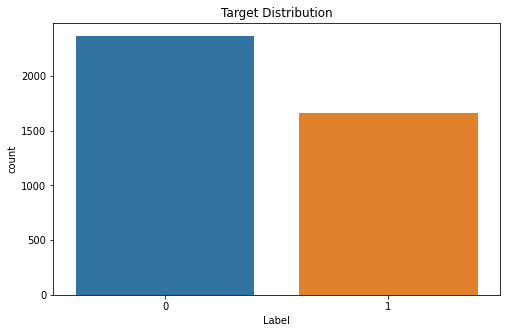

In [9]:
#visualizing target distribution 
f, ax = plt.subplots(1,1, figsize=(8,5))
sns.countplot(train['Label'],order = train['Label'].value_counts().index)
plt.title("Target Distribution")
plt.show()

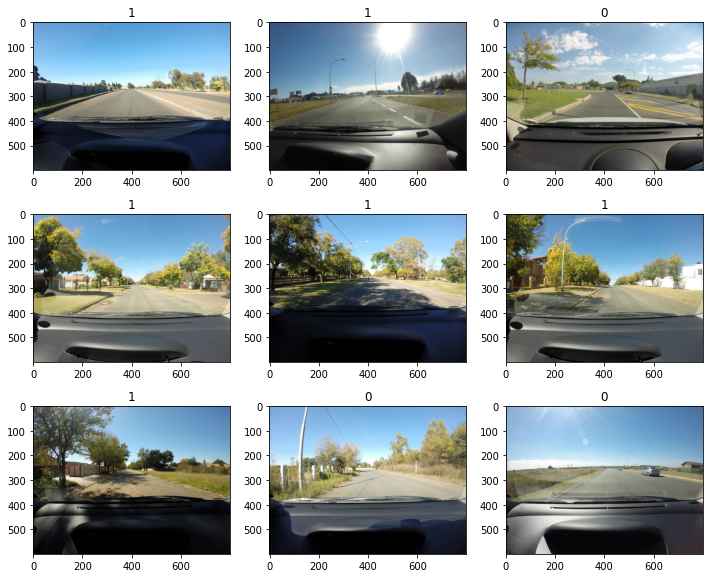

In [10]:
#visualizing random images
nrows = 3
rands = np.random.randint(train.shape[0], size=nrows**2)
fig = plt.figure(1,figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(train.loc[rands[i], 'filepath'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(train.loc[rands[i], 'Label'])

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train['Label'] = train['Label'].apply(str)

In [13]:
#spliting the training data into train and validation set
df_train , df_val = train_test_split(train, test_size=0.3, random_state=42)
print(df_train.Label.value_counts())
print(df_val.Label.value_counts())

0    1655
1    1163
Name: Label, dtype: int64
0    710
1    498
Name: Label, dtype: int64


In [14]:
#data generators
batch_size = 32  
image_size = (224, 224)
learning_rate = 0.1

train_steps = np.ceil(len(df_train) / batch_size)
val_steps = np.ceil(len(df_val) / batch_size )

classes = train.Label.unique().tolist()


# Slight Data Augementation too
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,horizontal_flip=True,
                             vertical_flip=True,shear_range=10,zoom_range=0.2,width_shift_range=0.1,
                             height_shift_range=0.1,channel_shift_range=10.)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_datagen.flow_from_dataframe(df_train,x_col='filepath', y_col='Label',
                                        target_size=image_size,classes=classes,
                                        batch_size=batch_size,
                                        class_mode='categorical', shuffle=True, seed=SEED)

val_ds = val_datagen.flow_from_dataframe(df_val,x_col='filepath', y_col='Label',
                                        target_size=image_size,classes=classes,
                                        batch_size=batch_size,
                                        class_mode='categorical', shuffle=False, seed=SEED)

test_ds = val_datagen.flow_from_dataframe(test, x_col='filepath',target_size=image_size, class_mode=None,
                                          shuffle=False,batch_size=batch_size)#set shuffle=False for test dataset not be shuffled

Found 2818 validated image filenames belonging to 2 classes.
Found 1208 validated image filenames belonging to 2 classes.
Found 1650 validated image filenames.


### MODELING (Using transfer learning)

In [21]:
def BuildModel (pretrained=VGG16):

    base_model = pretrained(include_top=False, weights='imagenet', input_shape=(224, 224,3)) #include_top=False to remove the last layer 

    for layer in base_model.layers:
        layer.trainable = False   #freeze trainable layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Dense(3072, activation='relu', )(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    output = Dense(2, activation='softmax')(x) 
    
    model = Model(base_model.input, output)
    
    return model

In [23]:
model = BuildModel()

In [24]:
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC'])

In [27]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
chkpt_path = os.path.join("/content/drive/MyDrive/Zindi pothole image classification/data/models/", f"tb_model.h5", )
checkpoint = ModelCheckpoint(chkpt_path, monitor='val_loss',mode='auto', verbose=1, save_best_only=True,)

In [28]:
history = model.fit(train_ds, epochs=5,steps_per_epoch=train_steps, callbacks=[earlystop, checkpoint],
                    verbose=1, shuffle=False,validation_data=(val_ds), validation_steps= val_steps)

Epoch 1/5
89/89 [==============================] - 2157s 24s/step - loss: 4.4675 - auc: 0.7351 - val_loss: 2.0484 - val_auc: 0.8477

Epoch 00001: val_loss improved from inf to 2.04842, saving model to /content/drive/MyDrive/Zindi pothole image classification/data/models/tb_model.h5
Epoch 2/5
89/89 [==============================] - 2109s 24s/step - loss: 1.4107 - auc: 0.7789 - val_loss: 2.8414 - val_auc: 0.6769

Epoch 00002: val_loss did not improve from 2.04842
Epoch 3/5
89/89 [==============================] - 2138s 24s/step - loss: 1.3846 - auc: 0.7605 - val_loss: 2.4829 - val_auc: 0.6967

Epoch 00003: val_loss did not improve from 2.04842
Epoch 4/5
89/89 [==============================] - 2097s 24s/step - loss: 3.0854 - auc: 0.7436 - val_loss: 3.1682 - val_auc: 0.8024

Epoch 00004: val_loss did not improve from 2.04842
Epoch 5/5
89/89 [==============================] - 2104s 24s/step - loss: 3.6796 - auc: 0.7296 - val_loss: 1.8130 - val_auc: 0.8432

Epoch 00005: val_loss improved f

In [29]:
#AUC
y_pred = model.predict(val_ds, verbose=1)[:, 1] 
fpr, tpr, thresholds = roc_curve(val_ds.classes, y_pred)
auc = auc(fpr, tpr)
auc

38/38 [==============================] - 633s 17s/step


0.9024068103399513

### SUBMISSION

In [31]:
#make predictions on test data
predictions = model.predict(test_ds)[:, 1]

In [32]:
submission = pd.DataFrame()
submission['Image_ID'] = test_names
submission['Label'] = predictions

In [33]:
submission.head()

,Image_ID,Label
0,nRhHxqLhDlJsiXc,4.530898e-18
1,gbSntVovxgHQrmO,5.431354e-15
2,nqOobGmvgEOiPms,2.873504e-27
3,oIkPTooLcIbZKlF,9.990057e-01
4,eSKxsTTJDQzkjgD,7.331663e-08


In [34]:
submission.to_csv('submission.csv', index=False)